# Customer Churn Prediction for Sparkify using PySpark

This notebook is used to explore a smaller subset (128MB) of the full dataset with Spark before deploying the cluster on the cloud. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from time import time

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local[*]").appName("Sparkify").getOrCreate()

## Data Cleaning

In [3]:
# load the dataset 
df = spark.read.json("mini_sparkify_event_data.json")
# check the schema of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
print('The dataset has {} rows.'.format(df.count()))

The dataset has 286500 rows.


In [5]:
# display the Spark dataframe
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


* Note that converting a Spark dataframe to a Pandas one here is for display purpose only. This is not recommended when one has to deal with fairly large dataframes (If this is the case, use the following configuration will help: spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true") ), as Pandas needs to load all the data into memory. See https://stackoverflow.com/questions/39067505/pyspark-display-a-spark-data-frame-in-a-table-format.

#### Check values for categorical variables of interest

In [6]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

In [7]:
df.select('gender').distinct().collect()

[Row(gender='F'), Row(gender=None), Row(gender='M')]

In [8]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [9]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

In [10]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

#### Check duration of records

In [11]:
df.select(min(to_timestamp(col('ts')/1000)).alias('Start time')).show()

+-------------------+
|         Start time|
+-------------------+
|2018-09-30 17:01:57|
+-------------------+



In [12]:
df.select(max(to_timestamp(col('ts')/1000)).alias('End time')).show()

+-------------------+
|           End time|
+-------------------+
|2018-12-02 17:11:16|
+-------------------+



The duration of records is about 2 months.

#### Check null values

In [13]:
# check the count of null values for each column
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


We can see that variables with null values can be divided into two groups, i.e.:

* Group 1 (user-related): firstName, gender, lastName, location, registration and userAgent
* Group 2 (song-related): artist, length and song

Variables in each group seem to be tied in a certain way with nulls.

In [14]:
df.where('firstName is null').limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,
5,None,Logged Out,None,None,3,None,None,free,None,PUT,Login,None,240,None,307,1538356679000,None,
6,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,100,None,307,1538358102000,None,
7,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,241,None,307,1538360117000,None,
8,None,Logged Out,None,None,14,None,None,free,None,GET,Home,None,187,None,200,1538361527000,None,
9,None,Logged Out,None,None,15,None,None,free,None,PUT,Login,None,187,None,307,1538361528000,None,


It can be seen that when **auth** is *LoggedOut*, variables in both groups are null and **userId** is an empty string. 

In [15]:
df.where(df['userId'] == '').groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



The result above shows all the rows with missing values in the **userId** column and all other user-related columns correspond to *Logged Out* or *Guest* authentication levels.

In [16]:
df.where('artist is null').limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,None,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,None,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
5,None,Logged In,Micah,M,95,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1.538332e+12,8,None,307,1538355306000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,None,Logged In,Micah,M,97,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1.538332e+12,8,None,200,1538355504000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,None,Logged In,Micah,M,99,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1.538332e+12,8,None,307,1538355687000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
8,None,Logged In,Ashlynn,F,9,Williams,None,free,"Tallahassee, FL",PUT,Thumbs Up,1.537365e+12,217,None,307,1538355711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74
9,None,Logged Out,None,None,100,None,None,free,None,GET,Home,NaN,8,None,200,1538355745000,None,


In [17]:
set(df.select('page').distinct().collect())-set(df.select('page').where('artist is null').distinct().collect())

{Row(page='NextSong')}

We find that the variables in Group 2 are null whenever **page** is not *NextSong*, which makes sense since these variables are song-related.

In [18]:
def clean_data(df):
    """Clean a Sparkify dataset 
    
    Args:
    df: (spark dataframe) a Sparkify dataset
    
    Returns:
    df: (spark dataframe) a preprocessed Sparkify dataset
    """
    # remove user id with empty strings
    df = df.filter(df['userId'] != '')
    
    # convert 'registration' and 'ts' to date format
    df = df \
        .withColumn('registrationTime', to_timestamp(col('registration')/1000)) \
        .withColumn('time', to_timestamp(col('ts')/1000)) 
    
    # replace location with first listed state 
    state_udf = udf(lambda x: x.split(', ')[1].split('-')[0])
    df = df.withColumn('location', state_udf('location'))
        
    return df

df = clean_data(df)

## Feature Engineering and Exploratory Data Analysis

Once we've familiarized ourselves with the data, we build out the features we find promising and perform exploratory data analysis to observe the demographic and behavioral difference between those who stayed and those who churned. 

### Define Churn

First, we use the *Cancellation Confirmation* events of the **page** column to define the customer churn. 

In [19]:
userWindow = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)

In [20]:
# label churned users to be 1 and unchurned users to be 0 
df = df \
    .withColumn('Churn', when(col('page')=='Cancellation Confirmation', 1).otherwise(0)) \
    .withColumn('Churn', max('Churn').over(userWindow))

In [21]:
df.dropDuplicates(['userId']).groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



There are 52 churned users in a total of 225 users in the dataset. That's about 23.1% churn rate.

### Build features

Next, we investigate the following factors of interest for their impact on churn:

* gender
* location
* latest level
* registration duration
* average session duration
* aggregated activities / observation period

In this list, gender and location represent a user's demographic information. We notice Spakify's users reside across 41 states. If we one hot encode the location feature, we will add 40 binary columns to a dataset with only 225 samples, which may potentially cause the curse of dimensionality. To address this issue, we replace each state by its corresponding geographical division (data source: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf) so that 41 states are assigned to 9 divisions.

In [22]:
print('The dataset includes {} states.'.format(df.dropDuplicates(['location']).count()))

The dataset includes 41 states.


In [23]:
region_df = spark.read.csv('us_regions.csv', header=True)
region_df.show(5)

+----------+----------+------+------------------+
|     State|State Code|Region|          Division|
+----------+----------+------+------------------+
|    Alaska|        AK|  West|           Pacific|
|   Alabama|        AL| South|East South Central|
|  Arkansas|        AR| South|West South Central|
|   Arizona|        AZ|  West|          Mountain|
|California|        CA|  West|           Pacific|
+----------+----------+------+------------------+
only showing top 5 rows



In [24]:
# find the user's geographical division based on the location
division_udf = udf(lambda x: 'location' + x.replace(' ', ''))

location_df = df.select(['userId', 'location']).dropDuplicates(['userId'])
location_df = location_df.join(region_df, location_df['location']==region_df["State Code"], how='left') \
            .select(['userId', col("Division").alias("location")]) \
            .withColumn('location', division_udf('location'))

# one hot encode the 'location' column by pivoting it 
location_df = location_df.groupBy('userId').pivot('location').agg(count('location').cast(IntegerType())).fillna(0)
# remove the last column (or any one) to keep the binary columns independent
location_df = location_df.drop(location_df.columns[-1]) 

location_df.limit(5).toPandas()

,userId,locationEastNorthCentral,locationEastSouthCentral,locationMiddleAtlantic,locationMountain,locationNewEngland,locationPacific,locationSouthAtlantic,locationWestNorthCentral
0,200002,1,0,0,0,0,0,0,0
1,100010,0,0,0,0,1,0,0,0
2,125,0,0,0,0,0,0,0,0
3,124,0,0,1,0,0,0,0,0
4,7,0,0,0,0,0,1,0,0


Now we engineer the rest of the features, all of which are related to a user's behavior.

In [25]:
# find the latest level of each user
df = df.withColumn('latestLevel', last(col('level')).over(userWindow))

In [26]:
# calculate the duration between registration to last activity (in days)
regist_duration_df = df.groupBy('userId') \
                    .agg(((last(col('ts'))-last(col('registration')))/1000/3600/24).alias('registDuration'))

In [27]:
# compute average session duration (in hours)
avg_session_duration_df = df \
    .groupBy(['userId', 'sessionId']).agg(min(col('ts')).alias('session_start'), max(col('ts')).alias('session_end'))\
    .groupBy('userId').agg(avg((col('session_end') - col('session_start'))/1000/3600).alias('avgSessionDuration'))

In [28]:
# define the default start and end of the observation period
obs_start_default = df.select(min(col('ts'))).collect()[0][0]
obs_end_default = df.select(max(col('ts'))).collect()[0][0]

In [29]:
# list users who registered after the start of the observation period
df.where(df['registration'] > obs_start_default).select(['userId','registrationTime']).dropDuplicates().show()

+------+-------------------+
|userId|   registrationTime|
+------+-------------------+
|   156|2018-11-26 07:49:14|
|   153|2018-11-02 22:42:17|
|   154|2018-11-03 11:00:21|
|   155|2018-11-04 14:27:50|
|   152|2018-10-30 16:03:28|
+------+-------------------+



In [30]:
# compute the observation period
df = df \
    .withColumn('obs_start', when(col('registration') > obs_start_default, first(col('ts')).over(userWindow)) \
                .otherwise(obs_start_default)) \
    .withColumn('end_state', last(col('page')).over(userWindow)) \
    .withColumn('obs_end', when(col('end_state') == 'Cancellation Confirmation', last(col('ts')).over(userWindow)) \
                .otherwise(obs_end_default)) \
    .withColumn('obsDays', (col('obs_end') - col('obs_start'))/1000/3600/24)

In [31]:
df.groupBy('page').count().orderBy('count', ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [32]:
# aggregate activity statistics
user_df = df.groupBy('userId') \
.agg(first(col('Churn')).alias('Churn'), \
     first(when(col('gender') == 'M', 1).otherwise(0)).alias('gender'), \
     first(when(col('latestLevel') == 'paid', 1).otherwise(0)).alias('latestLevel'), \
     first(col('obsDays')).alias('obsDays'), \
     sum(when(col('page') == 'NextSong', 1).otherwise(0)).alias('nSongs'), \
     sum(when(col('page') == 'Thumbs Up', 1).otherwise(0)).alias('nThumbsUp'), \
     sum(when(col('page') == 'Thumbs Down', 1).otherwise(0)).alias('nThumbsDown'), \
     sum(when((col('page') == 'Upgrade') | (col('page') == 'Submit Upgrade'), 1).otherwise(0)).alias('nUpgrade'), \
     sum(when((col('page') == 'Downgrade') | (col('page') == 'Submit Downgrade'), 1).otherwise(0)).alias('nDowngrade'), \
     sum(when(col('page') == 'Add Friend', 1).otherwise(0)).alias('nAddFriend'), \
     sum(when(col('page') == 'Add to Playlist', 1).otherwise(0)).alias("nAddPlaylist"), \
     sum(when(col('page') == 'Roll Advert', 1).otherwise(0)).alias('nAdvert'), \
     sum(when((col('page') == 'Help'), 1).otherwise(0)).alias('nHelp'), \
     sum(when((col('page') == 'Error'), 1).otherwise(0)).alias('nError')) \
.join(location_df, on='userId') \
.join(regist_duration_df, on='userId') \
.join(avg_session_duration_df, on='userId')

In [33]:
user_df = user_df \
        .withColumn('avgDailySongs', col('nSongs') / col('obsDays')) \
        .withColumn('avgDailyThumbsUp', col('nThumbsUp') / col('obsDays')) \
        .withColumn('avgDailyThumbsDown', col('nThumbsDown') / col('obsDays')) \
        .withColumn('avgDailyUpgrade', col('nUpgrade') / col('obsDays')) \
        .withColumn('avgDailyDowngrade', col('nDowngrade') / col('obsDays')) \
        .withColumn('avgDailyAddFriend', col('nAddFriend') / col('obsDays')) \
        .withColumn('avgDailyAddPlaylist', col('nAddPlaylist') / col('obsDays')) \
        .withColumn('avgDailyAdvert', col('nAdvert') / col('obsDays')) \
        .withColumn('avgDailyHelp', col('nHelp') / col('obsDays')) \
        .withColumn('avgDailyError', col('nError') / col('obsDays')) \
        .drop('userId', 'obsDays', 'nSongs', 'nThumbsUp', 'nThumbsDown', 'nUpgrade', 'nDowngrade', \
              'nAddFriend', 'nAddPlaylist', 'nAdvert', 'nHelp', 'nError')

user_df_pd = user_df.toPandas()

#### Analyze the relationships between each categorical feature and binary response

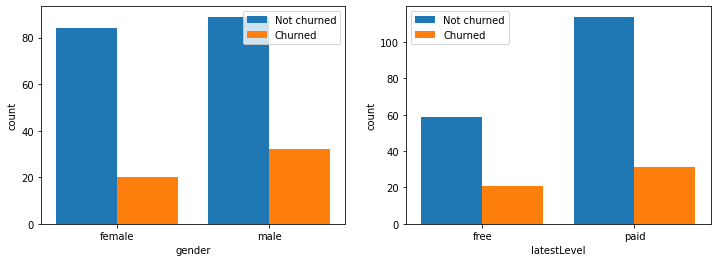

In [34]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.countplot(x='gender', data=user_df_pd, hue='Churn', saturation=1);
plt.legend(['Not churned', 'Churned']);
plt.xticks([0,1], ['female','male'])


plt.subplot(1,2,2)
sns.countplot(x='latestLevel', data=user_df_pd, hue='Churn', saturation=1);
plt.legend(['Not churned', 'Churned'])
plt.xticks([0,1], ['free', 'paid'])

plt.savefig('gender_latest_level_count.png', bbox_inches='tight', dpi=150)

In [35]:
user_df.select(['gender', 'Churn']).groupBy('gender', 'Churn').count().show()

+------+-----+-----+
|gender|Churn|count|
+------+-----+-----+
|     1|    0|   89|
|     1|    1|   32|
|     0|    0|   84|
|     0|    1|   20|
+------+-----+-----+



In [36]:
user_df.select(['latestLevel', 'Churn']).groupBy('latestLevel', 'Churn').count().show()

+-----------+-----+-----+
|latestLevel|Churn|count|
+-----------+-----+-----+
|          1|    0|  114|
|          1|    1|   31|
|          0|    0|   59|
|          0|    1|   21|
+-----------+-----+-----+



We can see that the churn rates are only slightly higher for male users (female vs. male: 19.2% vs. 26.4%) and free users (free vs. paid: 26.3% vs. 21.4%). 

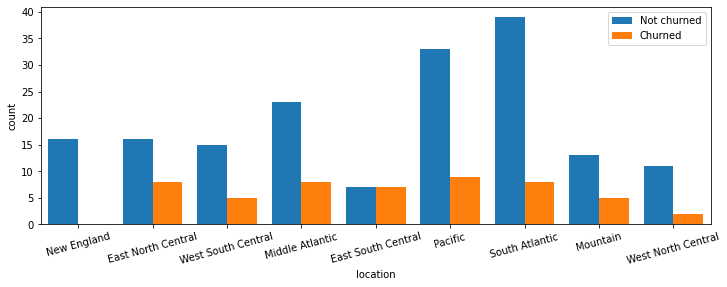

In [37]:
location_churn_df = df.select(['userId', 'location', 'Churn']).dropDuplicates(['userId'])
location_churn_df = location_churn_df.join(region_df, location_churn_df['location']==region_df['State Code'], how='left') \
                    .select(['userId', col("Division").alias("location"), 'Churn'])

# plot location vs. churn
plt.figure(figsize = (12,4))
sns.countplot(x='location', data=location_churn_df.toPandas(), hue='Churn', saturation=1);
plt.xticks(rotation=15)
plt.legend(['Not churned', 'Churned'], loc='upper right');

plt.savefig('location_count.png', bbox_inches='tight', dpi=150)

We notice that the churn rates differ greatly among divisions. For example, New England area has zero churn rate while there are as many churned users as unchurned ones in east south central area.

#### Analyze the relationships between each numerical feature and binary response

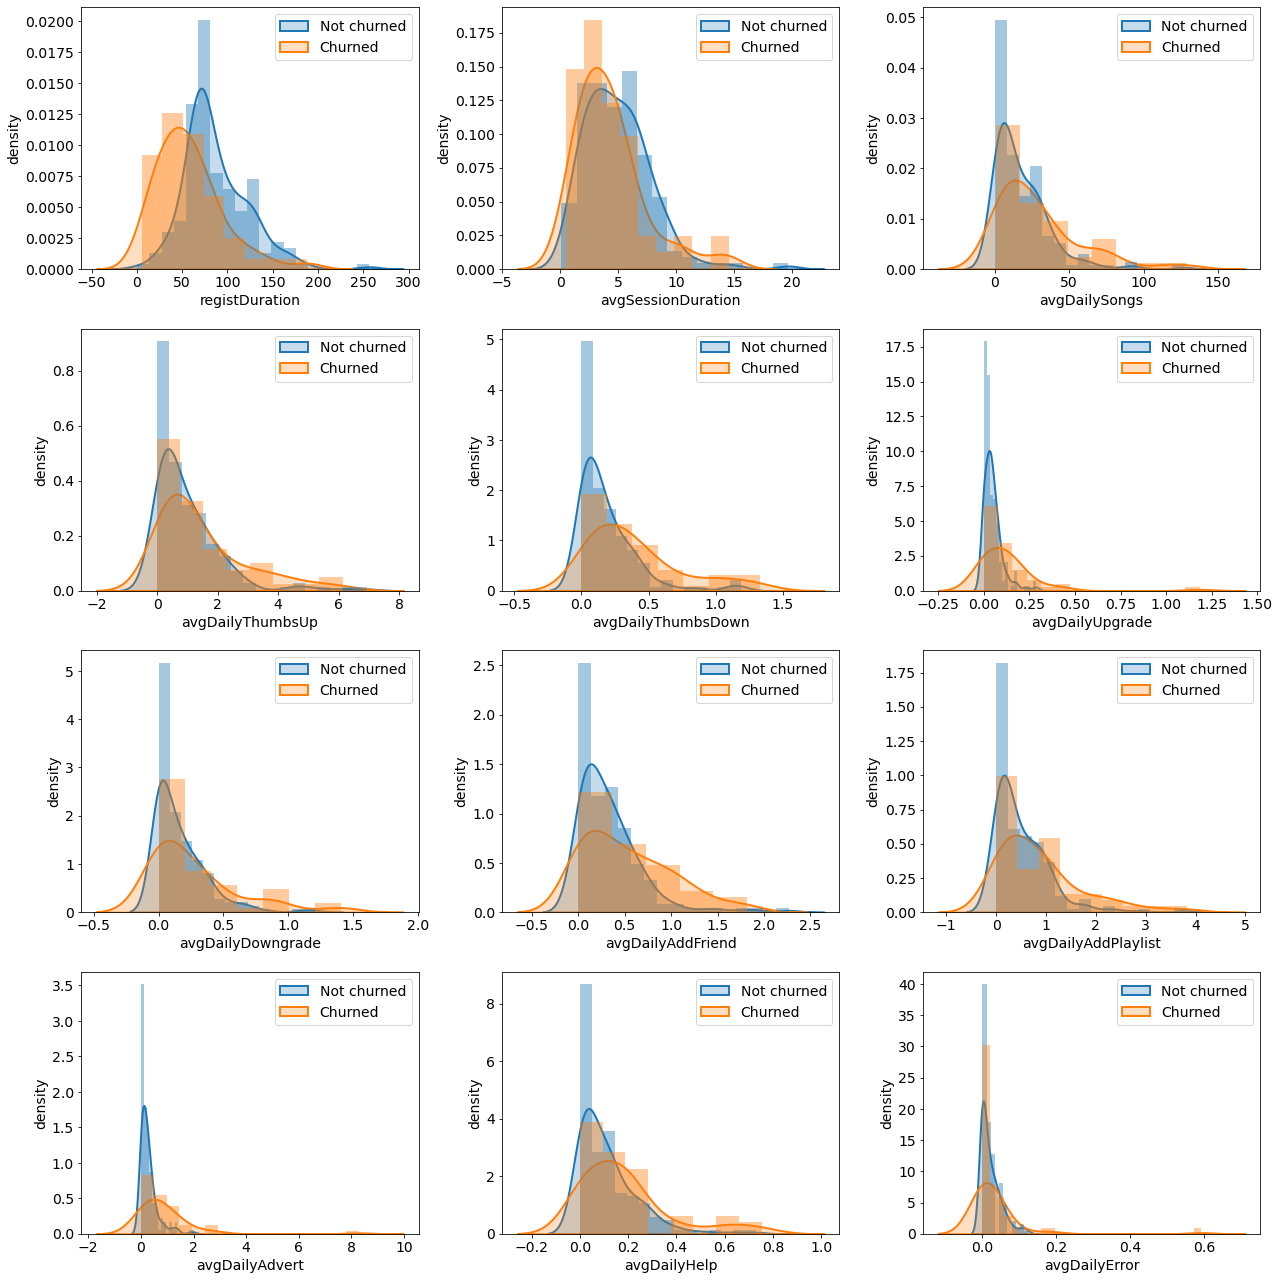

In [38]:
# plot numerical features vs. churn
num_cols = [field.name for field in user_df.schema.fields if field.dataType != IntegerType()]

plt.figure(figsize=(18,18))
with plt.style.context({'font.size': 14}): # change the font size temporarily
    for i in range(len(num_cols)):
        plt.subplot(4,3,i+1)
        plt.tight_layout()
        sns.distplot(user_df_pd[user_df_pd['Churn'] == 0][num_cols[i]], kde_kws={'shade':True, 'linewidth':2}, color='C0')
        sns.distplot(user_df_pd[user_df_pd['Churn'] == 1][num_cols[i]], kde_kws={'shade':True, 'linewidth':2}, color='C1')
        plt.legend(['Not churned','Churned'])
        plt.xlabel(num_cols[i])
        plt.ylabel('density')

plt.savefig('numerical_features_hist.png', dpi=150)

We find:

* Churned users have a shorter registration duration on average.
* Churned users give more thumbs down, need more help, and have to watch more advertisements per day.
* There is no significant difference between churned and unchurned users in terms of average session duration.

### Analyze feature correlations

Before we start modeling, we also need to understand the correlation between the response variable and the features as well as the correlation between the features. The **Correlation** function in the **ml.stat** subpackage requires a column of type Vector. Thus, we need to convert the columns into a vector column first and then apply the correlation.

In [39]:
vec_col = 'corr_features'
   
# assemble all vector columns into one vector column
assembler = VectorAssembler(inputCols=user_df.columns, outputCol=vec_col)
corr_df = assembler.transform(user_df).select(vec_col)

# compute the correlation between 'churn' and every feature and the correlation between each pair of features
corr_mat = Correlation.corr(corr_df, vec_col)
# convert the corrlation matrix to a pandas dataframe with column names
corr_values = corr_mat.collect()[0][0].values
corr_mat_pd = pd.DataFrame(corr_values.reshape(-1, len(user_df.columns)), \
                           index=user_df.columns, columns=user_df.columns)

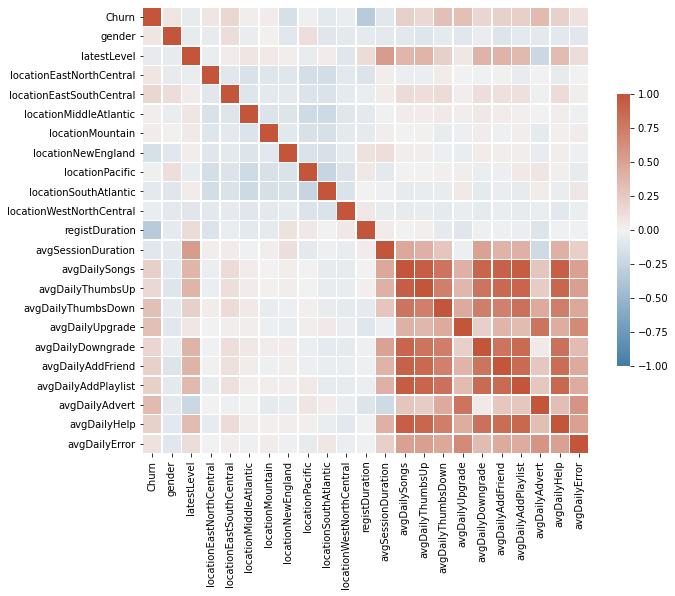

In [40]:
# plot feature correlations
plt.figure(figsize=(10,10))
sns.heatmap(corr_mat_pd, vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 20, as_cmap=True), 
            linewidths=.5, cbar_kws={"shrink": .5}, square=True)
plt.savefig('feature_correlations.png', bbox_inches='tight', dpi=150)

From the heatmap above, we find

* Many page event activities, such as **avgDailySongs**, **avgDailyThumbsUp**, **avgDailyDowngrade**, **avgDailyAddFriend**, **avgDailyAddPlaylist** and **avgDailyHelp**, are highly correlated. To avoid multicollinearity in the data, we only retain **avgDailyAddPlaylist** here (as it has the highest correlation with **Churn**). On the other hand, location features are weakly correlated with each other.

* **Churn** doesn not appear to have strong correlations with any features.  **registDuration** is negatively correlated with **Churn** while **avgDailyAdvert** has the highest positive correlation with **Churn**. It also shows that **gender**, **latestLevel**, **avgSessionDuration** and many location features all have very low correlation with **Churn**. This is consistent with our previous findings through direct visualization. However, the Pearson correlation assumes a linear relationship, and a low correlation simply means that there is no linear relationship between these features and the response variable. The data might still have a nonlinear relationship and should be included in the modeling for now. 

The code that automates the removal of highly correlated features is shown below:

In [41]:
# construct an adjacency matrix where high correlation (> 0.85) is labeled as 1, otherwise 0
is_high_corr = np.abs(corr_mat_pd.values) > 0.85
adj_mat = csr_matrix(is_high_corr.astype(int) - np.identity(len(user_df.columns)))

# find groups of highly correlated features by finding the connected components in the adjacency matrix
_, corr_labels = connected_components(csgraph=adj_mat, directed=False)
unique, unique_counts = np.unique(corr_labels, return_counts=True)
# get groups with size > 1
high_corr_labels = unique[unique_counts > 1]

# if there is at least one group of highly correlated features
if len(high_corr_labels) > 0:
    # map the label indices of highly correlated features to their column names
    print('Highly correlated features include:')
    high_corr_col_dict = {}
    for high_corr_label in high_corr_labels:
        high_corr_col_dict[high_corr_label] = [col_name for corr_label, col_name in zip(corr_labels, user_df.columns) 
                                               if corr_label == high_corr_label]
        print(high_corr_col_dict[high_corr_label])
        
    print('\nFeatures to keep:')
    cols_to_drop = []
    for col_name_list in high_corr_col_dict.values(): 
        # keep the feature that has the highest correlation with 'Churn'
        col_to_keep = corr_mat_pd.loc[col_name_list,'Churn'].idxmax()
        print(col_to_keep)
        # remove the other features to avoid multicollinearity 
        col_name_list.remove(col_to_keep)
        corr_mat_pd.drop(index=col_name_list, columns=col_name_list, inplace=True)
        cols_to_drop.extend(col_name_list)

Highly correlated features include:
['avgDailySongs', 'avgDailyThumbsUp', 'avgDailyDowngrade', 'avgDailyAddFriend', 'avgDailyAddPlaylist', 'avgDailyHelp']

Features to keep:
avgDailyAddPlaylist


In [42]:
model_df = user_df.drop(*cols_to_drop)
model_df.printSchema()

root
 |-- Churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- latestLevel: integer (nullable = true)
 |-- locationEastNorthCentral: integer (nullable = true)
 |-- locationEastSouthCentral: integer (nullable = true)
 |-- locationMiddleAtlantic: integer (nullable = true)
 |-- locationMountain: integer (nullable = true)
 |-- locationNewEngland: integer (nullable = true)
 |-- locationPacific: integer (nullable = true)
 |-- locationSouthAtlantic: integer (nullable = true)
 |-- locationWestNorthCentral: integer (nullable = true)
 |-- registDuration: double (nullable = true)
 |-- avgSessionDuration: double (nullable = true)
 |-- avgDailyThumbsDown: double (nullable = true)
 |-- avgDailyUpgrade: double (nullable = true)
 |-- avgDailyAddPlaylist: double (nullable = true)
 |-- avgDailyAdvert: double (nullable = true)
 |-- avgDailyError: double (nullable = true)



Now a total of 10 binary features and 7 numerical features are ready for modeling as inputs.

## Modeling and Evaluation

We first randomly split the entire dataset into a training and a test set in 8:2 ratio using stratified sampling based on **Churn**.

In [43]:
# split the data into train and test sets using stratified sampling based on 'Churn'
train = model_df.sampleBy('Churn', fractions={0: 0.8, 1: 0.8}, seed=2020)
test = model_df.subtract(train)
print('Train and test set each includes {} and {} users, respectively, where {} users churn in the test set.'
      .format(train.count(), test.count(), test.where(col('Churn') == 1).count()))

Train and test set each includes 181 and 44 users, respectively, where 10 users churn in the test set.


Three binary classifiers supported in Spark are selected as candidate models: logistic regression, random forest classifier and gradient-boosted tree classifier. Both random forest and gradient-boosted techniques employ an ensemble of decision trees (base estimators) to improve the predictive capability over a single estimator. The difference is random forest builds several estimators independently and then average their predictions, while gradient-boosted tree buils base estimators sequentially to generate a powerful ensemble. 

### Build training pipelines

For each binary classifier, we build a pipeline to facilitate the machine learning workflow and prevent data leakage.

In [44]:
num_cols = [field.name for field in model_df.schema.fields if field.dataType != IntegerType()]
bin_cols = [col for col in model_df.columns if col not in num_cols + ['Churn']]

# assemble numerical columns to a single vector column 
num_assembler = VectorAssembler(inputCols=num_cols, outputCol='num_features')
    
# scale each numberical feature within the range [0,1] 
scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')
    
# assemble all vector columns into one vector column
assembler = VectorAssembler(inputCols= bin_cols + ['scaled_features'], outputCol='features')

# logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='Churn')
pipeline_lr = Pipeline(stages=[num_assembler, scaler, assembler, lr])

# random forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Churn', seed=2020)
pipeline_rf = Pipeline(stages=[num_assembler, scaler, assembler, rf])

# gradient-boosted tree classifier
gb = GBTClassifier(featuresCol='features', labelCol='Churn', seed=2020)
pipeline_gb = Pipeline(stages=[num_assembler, scaler, assembler, gb])

### Performance metrics

We choose to use the **f1 score** as a performance metric since our dataset is imbalanced. The f1 score is the harmonic mean of the precision and recall. Spark's **MulticlassClassificationEvaluator** module in the **ml.evaluation** subpackage only provides weighted f1 score, precision and recall metrics. For an imbalanced dataset dominated by the negative class, the weighted metrics will inflate the corresponding metrics from the positive class which we are more interested in. For this reason, we employ the **MulticlassMetrics** module from Spark's **mllib.evaluation** subpackage to calculate these metrics for each class. Another metric we look at is the **area under the precision-recall curve (AUC-PR)**. For binary classifier evaluation, precision-recall curves are more useful in practice than the receiver operating characteristic (ROC) curves for problems where the "positive" class is more of interest than the negative class. See: http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf 

In [45]:
def print_metrics(pred, label='Churn'):
    """Print evaluation metrics on a test set
    
    Args:
    pred: (spark dataframe) a test set 
    
    Returns:
    summary: (pandas dataframe) a summary of evaluation metrics
    """
    eval_metrics = {}

    # compute area under PR curve
    evaluator = BinaryClassificationEvaluator(labelCol=label)
    auc_pr = evaluator.evaluate(pred, {evaluator.metricName:'areaUnderPR'})

    # compute precision, recall and f1 score
    predictionAndLabels = pred.select('prediction', label)
    # both 'prediction' and label in predictionAndLabels need to be cast to float type and 
    # map to tuple before calling 'MulticlassMetrics'
    metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

    # get overall statistics
    eval_metrics['overall'] = [metrics.weightedPrecision, metrics.weightedRecall, \
                               metrics.weightedFMeasure(), auc_pr]

    # get statistics by class
    classes = [0.0, 1.0]
    for cls in classes:
        eval_metrics['class ' + str(int(cls))] = [metrics.precision(cls), metrics.recall(cls), \
                                                  metrics.fMeasure(cls), '']

    # convert to a pandas dataframe for display
    summary = pd.DataFrame.from_dict(eval_metrics, orient='index', \
                                     columns=['precision', 'recall', 'f1 score', 'AUC-PR'])   
    
    return summary

### Hyperparameter tuning

The search spaces of hyperparameters for the three models are listed below:

* **Logistic Regression**
    - *maxIter* (maximum number of iterations, default=100): [10, 30]
    - *regParam* (regularization parameter, default=0.0): [0.0, 0.1]
    - *elasticNetParam* (mixing parameter - 0 for L2 penalty, 1 for L1 penalty, default=0.0: [0.0, 0.5]

* **Random Forest Classifier**
    - *maxDepth* (maximum tree depth, default=5): [4, 5]
    - *numTrees* (number of trees, default=20): [20, 100, 200]

* **Gradient-Boosted Tree Classifier**
    - *maxDepth* (maximum tree depth, default=5): [4, 5]
    - *maxIter* (maximum number of iterations, default=20): [20, 100]

We perform a grid search with 4-fold cross validation to test the performance of these hyperparameter combinations measured by **AUC-PR**. An advantage of using AUC-PR is that one does not need to worry about optimizing the probability threshold that splits the model outputs into positive and negative predictions, as it summarizes the model performance over all possible thresholds.

#### Logistic regression

In [46]:
# set hyperparameters for tuning
paramGrid = ParamGridBuilder() \
            .addGrid(lr.maxIter, [10, 30]) \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
            .build()


# grid search with cross validation    
crossval_lr = CrossValidator(estimator = pipeline_lr,
                             estimatorParamMaps = paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR'),
                             numFolds = 4)

start = time()
cv_lr = crossval_lr.fit(train)
end = time()
print('Total training time for hyperparameter tuning on logistic regression: {:.0f} seconds'.format(end - start))

Total training time for hyperparameter tuning on logistic regression: 436 seconds


In [47]:
# store grid search results in a dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_lr.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC-PR'] = cv_lr.avgMetrics
params_pd

,maxIter,regParam,elasticNetParam,AUC-PR
0,10,0.0,0.0,0.528178
1,10,0.0,0.5,0.528178
2,10,0.1,0.0,0.588495
3,10,0.1,0.5,0.605653
4,30,0.0,0.0,0.515378
5,30,0.0,0.5,0.515378
6,30,0.1,0.0,0.592072
7,30,0.1,0.5,0.600646


In [48]:
test_prediction = cv_lr.transform(test)
print_metrics(test_prediction)

,precision,recall,f1 score,AUC-PR
overall,0.852814,0.818182,0.767145,0.722162
class 0,0.809524,1.000000,0.894737,
class 1,1.000000,0.200000,0.333333,


#### Random forest classifier

In [49]:
# set hyperparameters for tuning
paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 100, 200]) \
            .addGrid(rf.maxDepth, [4, 5]) \
            .build()  

# grid search with cross validation    
crossval_rf = CrossValidator(estimator = pipeline_rf,
                             estimatorParamMaps = paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR'),
                             numFolds = 4)

start = time()
cv_rf = crossval_rf.fit(train)
end = time()
print('Total training time for hyperparameter tuning on random forest classifier: {:.0f} seconds'.format(end - start))

Total training time for hyperparameter tuning on random forest classifier: 397 seconds


In [50]:
# store grid search results in a dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC-PR'] = cv_rf.avgMetrics
params_pd

,numTrees,maxDepth,AUC-PR
0,20,4,0.671751
1,20,5,0.632830
2,100,4,0.680891
3,100,5,0.667711
4,200,4,0.676326
5,200,5,0.669651


In [51]:
test_prediction = cv_rf.transform(test)
print_metrics(test_prediction)

,precision,recall,f1 score,AUC-PR
overall,0.857323,0.863636,0.858009,0.767631
class 0,0.888889,0.941176,0.914286,
class 1,0.750000,0.600000,0.666667,


#### Gradient-boosted tree classifier

In [52]:
# set hyperparameters for tuning
paramGrid = ParamGridBuilder() \
            .addGrid(gb.maxDepth, [4, 5]) \
            .addGrid(gb.maxIter, [20, 100]) \
            .build()

# grid search with cross validation    
crossval_gb = CrossValidator(estimator = pipeline_gb,
                             estimatorParamMaps = paramGrid,
                             evaluator = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR'),
                             numFolds = 4)

start = time()
cv_gb = crossval_gb.fit(train)
end = time()
print('Total training time for hyperparameter tuning on Gradient-boosted tree classifier: {:.0f} seconds'.format(end - start))

Total training time for hyperparameter tuning on Gradient-boosted tree classifier: 4837 seconds


In [53]:
# store grid search results in a dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC-PR'] = cv_gb.avgMetrics
params_pd

,maxDepth,maxIter,AUC-PR
0,4,20,0.434562
1,4,100,0.459551
2,5,20,0.459034
3,5,100,0.474385


In [54]:
test_prediction = cv_gb.transform(test)
print_metrics(test_prediction)

,precision,recall,f1 score,AUC-PR
overall,0.767100,0.727273,0.741477,0.647246
class 0,0.866667,0.764706,0.812500,
class 1,0.428571,0.600000,0.500000,


The results obtained on the test set from the best model of each classifier are summarized in the table below:

|Classifier                      | Parameters |Precision|          |Recall    |        |F1 score  |        |AUC-PR   | 
|:-------------------------------|:-----------|:-------:|----------|:--------:|--------|:--------:|--------|:-------:|
|                                |            |Overall  |Churned   |Overall   |Churned | Overall  |Churned |         |
|Logistic regression             |maxIter=10, regParam=0.1, elasticNetParam=0.5|0.85|1.00|0.82|0.20|0.77|0.33|0.72|
|Random forest classifier        |maxDepth=4, numTrees=100	   |0.86|**0.75**|0.86|**0.60**|**0.86**|**0.67**|**0.77**|   
|Gradient-boosted tree classifier|maxDepth=5, maxIter=100                      |0.77|0.43|0.73|0.60|0.74|0.50|0.65|

It shows that the random forest classifier outperforms both the logistic regression model and the gradient-boosted tree classifier in almost all categories. As aforementioned, the features and the response variable do not follow a linear relationship, which might suggest that a non-linear model will be more suited to the data. At a default probability threshold of 0.5, the random forest classifier is able to identify 60% of user churn, while 25% identified as churned users acutally satisfy with the service. If we want to target more users at risk of churning, we can lower the probability threshold, and a relatively high AUC-PR score of 0.77 will allow us to maintain a high precision that there will not be many more users with no intent of churning mistakenly targeted. 

### Feature importance

We extract feature importances from the trained model to gain a better understanding of the feature attributes to the model in predicting user churn.

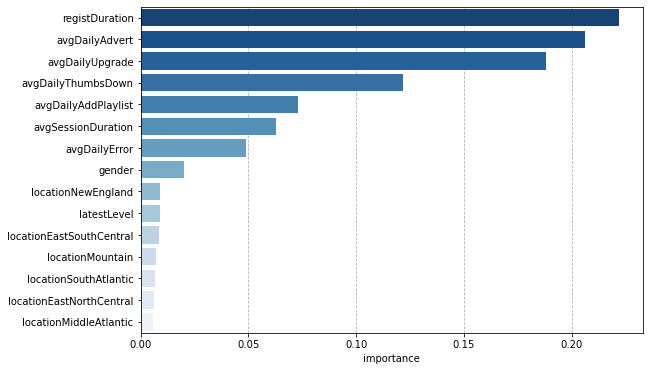

In [55]:
features = bin_cols + num_cols
importances = list(cv_rf.bestModel.stages[-1].featureImportances)
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# plot feature importance
plt.figure(figsize=(9,6))
sns.barplot(data=feat_imp_pd.head(15), y="feature", x="importance", palette='Blues_r', zorder=2)
plt.grid(axis='x', linestyle='--', zorder=0)
plt.ylabel('');
plt.savefig('feature_importance.png', bbox_inches='tight', dpi=150)

It can be seen that the most important feature for identifying churned users is the registration duration which makes sense since it directly reflects a user's willness to stay with the service. Another influential feature that plays a major role in churn prediction is avarage daily advertisements. Intuitively, the more advertisements a user has to watch, the more likely he/she is dissatisfied with the service.  Besides, average upgrades and thumbs down given per day that represent a user's strong inclination also help churn detection. 

The result also shows that gender, latest subscription level and each location feature contribute little to predicting churned users. Nevertheless, we notice that the churn rates of top location features, sch as those of New England and east south central areas are far different from the average churn rate.

## Conclusion

In this project, we managed to build an end-to-end scalable machine learning pipeline using Python API for Spark, PySpark, to identify churned users. The pipeline runs from cleaning and labeling data, through feature engineering and removing highly correlated featues, to model tuning using grid search with cross validation, to predicting the probabilities associated with users prone to churning.

As for model selection, the tuned random forest model with 100 trees and a maximum tree depth of 4 achieves the best result with an overall f1 score of 0.86. At a default probability threshold of 0.5, we are currently able to detect 60% of churned users. If deployed, the trained model could be used to predict users inclined to churn in advance, and we can provide them with special offers in the hope of keeping them from deleting their Sparkify accounts. On the other hand, 25% of the users who will receive special offers did not plan to discontinue the service and thus, would not need any special treatment. We need to emphasize that these results are based on the model that was only trained on 181 users and tested on 44 users with 10 positive cases. We expect the machine learning pipeline we develop here will generate better results with more training data in a full Sparkify dataset. 

### Reflection

Since the dataset is relatively clean, the most critical step in the model development process is feature engineering. It has been proved most of the engineered features based on users' behaviors, such as registration duration and avarage advertisements one receives daily, play vital roles in churn prediction rather than users' demographical information (e.g., gender and location). Besides, here are a few coding tips I've learned during the implementation of the predictive framework:

* Using **pivot** function with aggregation is a more concise way to one hot encode a categorical feature than using **StringIndexer** and **OneHotEncoderEstimator** functions.
* Spark's **sampleBy** and other sampling functions do not guarantee an exact split to the weights (fluctuations often happen if number of records is low). It only guarantees that each object has equal probability to be assigned to a specific subset. 
* The f1 score from the **MulticlassClassificationEvaluator** module in the **ml.evaluation** subpackage is a weighted version. If we want to know the f1 score, precision and recall for the positive class, as is often the case, we can use **mllib.evaluation** subpackage instead. 

### Improvement

There are several aspects in the modeling that can be addressed for further improvements:
* Test more engineered features that capture user's activity patterns and trends
* Test features such as **userAgent** that are ignored in the current modeling
* Apply principle component analysis (PCA) to input features before feeding them to training: PCA allows us to reduce the number of features and decorrelate them, which often helps to improve the performance of the model downstream.